In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.utils import resample
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import time
from alibi.confidence import TrustScore
import seaborn as sns
import shap
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
FOLDERPATH = '../'

### LOAD DATA AND MODEL

In [3]:
'''
LOAD MODEL
'''
model = load_model(FOLDERPATH+'tot-models/latest/model.h5')

'''
LOAD DATA
'''
data_path = FOLDERPATH+'old-data/'
train_data = pd.read_csv(data_path+'v3.2.2_train.csv')
test_data = pd.read_csv(data_path+'test.csv')

y_train,y_test = train_data[['TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow']], test_data[['TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow']]
X_train,X_test = train_data.drop(['Unnamed: 0','TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow'],axis=1),test_data.drop(['Unnamed: 0','TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow'],axis=1)

### FIT TRUST SCORE MODEL

In [ ]:
ts = TrustScore(alpha=.05,
                filter_type='distance_knn',
                k_filter=10,
                leaf_size=40,
                metric='euclidean',
                dist_filter_type='point')

In [13]:
ts.fit(X_train.values, np.argmax(y_train.values,axis=1), classes=5)

In [15]:
pkl.dump(ts,open(FOLDERPATH+'confidence-models/trust_model.pkl','wb'))

### LOAD TRUST SCORE MODEL AND DEFINE SOME FUNCTIONS

In [4]:
ts = pkl.load(open(FOLDERPATH+'confidence-models/trust_model.pkl','rb'))
randomIdx = pkl.load(open(FOLDERPATH+'old-data/old-data-randomIdx.pkl','rb'))

In [5]:
def get_trust_and_model_results(model,x,y):
    trust_score, closest_class = ts.score(x,y,k=2,dist_type='point')
    pred_score, pred = model.predict(x).max(axis=1), model.predict(x).argmax(axis=1)
    return pred_score, pred, trust_score, closest_class

def get_sample(X_data,y_data,s_no):
    x = X_data.values[s_no].reshape(1,-1)
    y = np.argmax(y_data.values,axis=1)[s_no]
    return x, y

### TRUST SCORE AND MODEL CONFIDENCE FOR SAMPLE

In [12]:
'''
Enter sample number in s_no
'''
s_no = 902
x, y = get_sample(X_test,y_test,s_no)
pred_score, pred, trust_score, closest_class = get_trust_and_model_results(model,x,y)

print(" Predicted Class: {:}\t Model confidence: {:}\n Closest Class: {:}\t Trust Score: {:}\n True Label: {:}"\
                         .format(pred.item(),round(pred_score.item(),4),closest_class.item(),round(trust_score.item(),4),y))

 Predicted Class: 2	 Model confidence: 0.9999
 Closest Class: 0	 Trust Score: 835879964298.3064
 True Label: 2


### TRUST AND MODEL CONFIDENCE ON RANDOM TEST SET VALUES

In [6]:
_X_test = X_test.values[randomIdx]
_y_test = np.argmax(y_test.values,axis=1)[randomIdx]
pred_score, pred, trust_score, closest_class = get_trust_and_model_results(model,_X_test,_y_test)

### TRUST ANALYSIS

In [7]:
incorrect_preds_idx = np.where(pred!=_y_test)[0]
correct_preds_idx = np.where(pred==_y_test)[0]

In [35]:
sum(trust_score[incorrect_preds_idx] >= 1)

359

In [36]:
sum(pred_score[incorrect_preds_idx] >= 0.5)

267

### DISTRIBUTION OF MODEL PREDICTION SCORES FOR CORRECTLY PREDICTED SAMPLES

<BarContainer object of 10 artists>

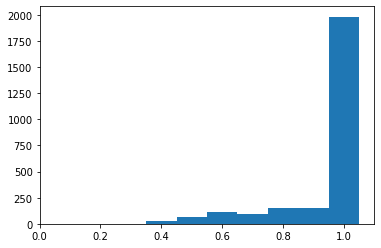

In [9]:
bins_range = np.arange(0,1.1,0.1)
counts,bin_edges = np.histogram(pred_score[correct_preds_idx],bins=bins_range)
plt.bar(x=bin_edges[1:],height=counts,width=0.1)

### DISTRIBUTION OF MODEL PREDICTION SCORES FOR INCORRECTLY PREDICTED SAMPLES

<BarContainer object of 10 artists>

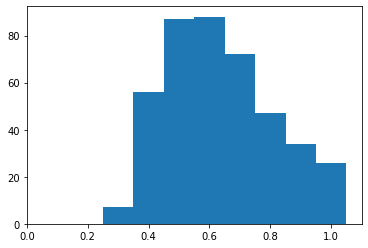

In [10]:
bins_range = np.arange(0,1.1,0.1)
counts,bin_edges = np.histogram(pred_score[incorrect_preds_idx],bins=bins_range)
plt.bar(x=bin_edges[1:],height=counts,width=0.1)
# sns.barplot(bin_edges[1:],counts)

### DISTRIBUTION OF TRUST SCORES FOR CORRECTLY PREDICTED SAMPLES

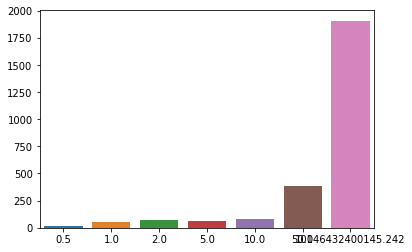

In [82]:
# scaler = MinMaxScaler()
# scaled_trust_score = scaler.fit_transform(trust_score[correct_preds_idx].reshape(-1,1))

bins_range = [0,0.5,1,2,5,10,50,trust_score[correct_preds_idx].max()]#np.arange(0,1.1,0.1)
counts,bin_edges = np.histogram(trust_score[correct_preds_idx],bins=bins_range)
# plt.bar(x=bin_edges[1:],height=counts)
sns.barplot(bin_edges[1:],counts)

### DISTRIBUTION OF TRUST SCORES FOR INCORRECTLY PREDICTED SAMPLES

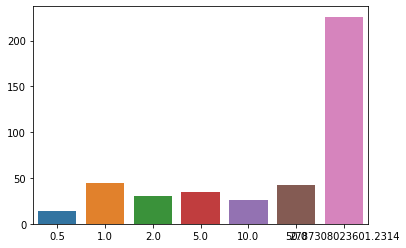

In [77]:
# scaler = MinMaxScaler()
# scaled_trust_score = scaler.fit_transform(trust_score[incorrect_preds_idx].reshape(-1,1))

bins_range = [0,0.5,1,2,5,10,50,trust_score[incorrect_preds_idx].max()]#np.arange(0,1.1,0.1)
counts,bin_edges = np.histogram(trust_score[incorrect_preds_idx],bins=bins_range)
# plt.bar(x=bin_edges[1:],height=counts,width=1)
sns.barplot(bin_edges[1:],counts)

### ANALYSING MODEL PERFORMANCE

In [34]:
print('Classification Report:\n\n',classification_report(y_test.values[randomIdx].argmax(axis=1),pred))

Classification Report:

               precision    recall  f1-score   support

           0       0.89      0.92      0.90       711
           1       0.78      0.97      0.87       221
           2       0.81      0.87      0.84       569
           3       0.90      0.78      0.83       953
           4       0.87      0.88      0.87       546

    accuracy                           0.86      3000
   macro avg       0.85      0.88      0.86      3000
weighted avg       0.86      0.86      0.86      3000



### UNDERSTANDING PRECISION AND RECALL

**Precision** is the number of samples correctly predicted as a particular class and **Recall** is the number of samples correctly predicted as a particular class over the total number of samples in that class. Confusing? Consider class 0 and ask a couple of questions. 
1. Over the total number of predictions for class 0, how many were correctly predicted?
2. Over the total number of samples labelled as class 0, how many were correctly predicted?

The answer to first question is **precision** and to the second question in **recall**. Still confusing? Follow the example!

In [95]:
class_to_select = 0

In [100]:
class_0_samples = np.where(y_test.values[randomIdx].argmax(axis=1) == class_to_select)[0]
support_0 = len(class_0_samples)
print("Support (total number of samples in that class): ",support_0)

Support (total number of samples in that class):  711


In [97]:
pred_class_0 = np.where(pred==class_to_select)[0]
print("Number of samples predicted as class-0: ",len(pred_class_0))

correct_preds = pred[correct_preds_idx]
print('Number of samples correctly predicted as class-0: ', sum(correct_preds==0))

precision = (sum(correct_preds==class_to_select)/len(pred_class_0))
print("\nPrecision: ", precision.round(2))

Number of samples predicted as class-0:  735
Number of samples correctly predicted as class-0:  651

Precision:  0.89


In [98]:
correct_preds = pred[correct_preds_idx]
print('Number of samples correctly predicted as class-0: ', sum(correct_preds==class_to_select))

print('Number of samples labelled as class 0: ', support_0)

recall = (sum(correct_preds==class_to_select)/support_0)
print("\nRecall: ", recall.round(2))

Number of samples correctly predicted as class-0:  651
Number of samples labelled as class 0:  711

Recall:  0.92


**f1 score** is the harmonic mean of precision and recall, $$\text{f1 score} = \frac{2\times \text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$$

In [99]:
f1 = (2*precision*recall/(precision+recall))
print("F1 Score: ", f1.round(2))

F1 Score:  0.9


### CLASS WISE DISTRIBUTION OF THE INCORRECTLY PREDICTED SAMPLES

In [124]:
classes, n_samples_classes = np.unique(pred[incorrect_preds_idx],return_counts=True)

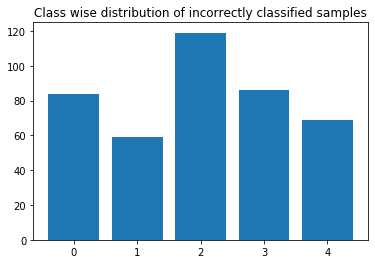

In [125]:
plt.bar(x=classes,height=n_samples_classes)
_=plt.title('Class wise distribution of incorrectly classified samples')

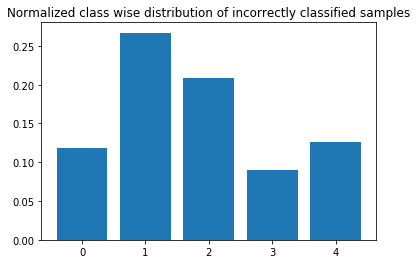

In [126]:
support_classes = [len(np.where(y_test.values[randomIdx].argmax(axis=1) == class_to_select)[0]) for class_to_select in classes]
plt.bar(x=classes,height=n_samples_classes/support_classes)
_=plt.title('Normalized class wise distribution of incorrectly classified samples')

### CLASS WISE DISTRIBUTION OF THE INCORRECTLY PREDICTED SAMPLES WHERE MODEL CONFIDENCE IS GREATER THAN 0.5

In [127]:
consideration = pred[incorrect_preds_idx][pred_score[incorrect_preds_idx]>=0.5]
classes, n_samples_classes = np.unique(consideration,return_counts=True)

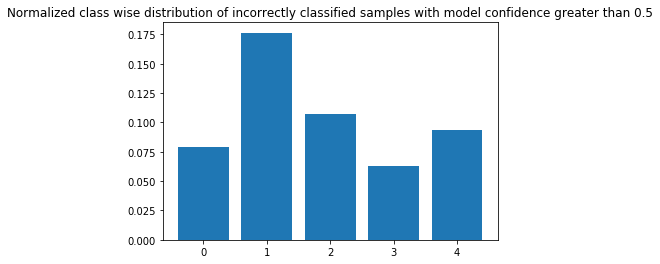

In [128]:
support_classes = [len(np.where(y_test.values[randomIdx].argmax(axis=1) == class_to_select)[0]) for class_to_select in classes]
plt.bar(x=classes,height=n_samples_classes/support_classes)
_=plt.title('Normalized class wise distribution of incorrectly classified samples with model confidence greater than 0.5')

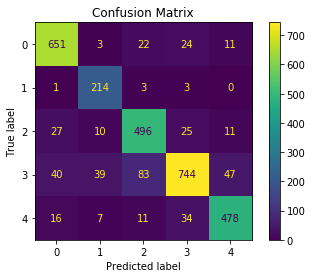

In [150]:
labels = y_test.values[randomIdx].argmax(axis=1)
preds = pred
cm = confusion_matrix(labels,preds)
cm_display = ConfusionMatrixDisplay(cm).plot()
_=plt.title('Confusion Matrix')

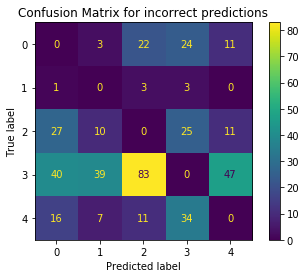

In [152]:
labels = y_test.values[randomIdx].argmax(axis=1)[incorrect_preds_idx]
preds = pred[incorrect_preds_idx]
cm = confusion_matrix(labels,preds)
cm_display = ConfusionMatrixDisplay(cm).plot()
_=plt.title('Confusion Matrix for incorrect predictions')

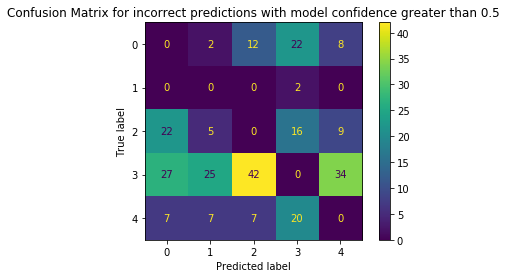

In [153]:
labels = y_test.values[randomIdx].argmax(axis=1)[incorrect_preds_idx][pred_score[incorrect_preds_idx]>=0.5]
preds = pred[incorrect_preds_idx][pred_score[incorrect_preds_idx]>=0.5]
cm = confusion_matrix(labels,preds)
cm_display = ConfusionMatrixDisplay(cm).plot()
_=plt.title('Confusion Matrix for incorrect predictions with model confidence greater than 0.5')